# Compact notebook with the implementation of the model

In [9]:
#En primer lugar, vamos a importar todos los paquetes que vamos a usar a lo largo del examen
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
#import netCDF4 as nc
from scipy import stats as sts
import scipy.stats as stats
from scipy import signal
from scipy.fft import fft 
#from statsmodels.tsa import stattools 
from cartopy import crs as ccrs # Cartography library
import cartopy as car
#import cmocean as cmo #Oceanographic library for colormaps
#import plotly as plty
import matplotlib.patches as mpatches
import cartopy.io.img_tiles as cimgt
import numpy.linalg as linalg
import numpy.ma as ma
from scipy.stats import pearsonr
import matplotlib.dates as mdates
from cartopy.util import add_cyclic_point #esto es para la banda de latitud que queda en blanco en 0ª
import matplotlib.dates as mdates
import cartopy.io.shapereader as shpreader

#The following two lines are coded to avoid the warning unharmful message.
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras as keras


## * Defined Functions

In [10]:
def data_mining(relative_path,lat_lims,lon_lims,time_lims, scale=1,rotate_180=False,rotate_360=False,regrid=False,regrid_degree=2,overlapping=False,variable_name=None):
    data= xr.open_dataset(relative_path)/scale
    time = data['time'].astype('datetime64[M]') #esto es para facilitar el trato con los datos
    data = data.assign_coords(time=time)
    if rotate_180:
        data= data.assign_coords(longitude=(((data.longitude + 180) % 360) - 180)).sortby('longitude')
    if rotate_360:
        data= data.assign_coords(longitude=np.where(data.longitude < 0,360+(data.longitude),data.longitude)).sortby('longitude')
    data= data.sel(latitude= slice(lat_lims[0],lat_lims[1]),longitude= slice(lon_lims[0],lon_lims[1]),time=slice(str(time_lims[0]),str(time_lims[1])))
    if regrid:
        lon_regrid= np.arange(lon_lims[0],lon_lims[1],regrid_degree)
        lat_regrid= np.arange(lat_lims[0],lat_lims[1],-regrid_degree) 
        data= data.interp(longitude=np.array(lon_regrid)).interp(latitude=np.array(lat_regrid))
    latitude= data.latitude
    longitude= data.longitude
    data= data[str(variable_name)]
    if overlapping:
        creg, longitude = add_cyclic_point(np.array(data), coord=longitude)       
        data = xr.DataArray(
            data=creg,
            dims=["time", "latitude", "longitude"],
            coords=dict(
                longitude=(["longitude"], np.array(longitude)),
                latitude=(["latitude"], np.array(latitude)),
                time=np.array(data.time)))
    return data,latitude,longitude

def data_selection(data, months, years, months_to_drop,years_out,reference_period):
    data_red = data.sel(time=slice(f"{years[0]}", f"{years[-1]}"))
    data_red = data_red.sel(time=np.isin(data['time.month'], months))
    data_red = data_red.drop_sel(time=months_to_drop)
    data_red = data_red.groupby('time.month')
    mean_data= 0
    for i in months:
        mean_data += np.array(data_red[i])
    mean_data /=len(months)
    data_red = xr.DataArray(data=mean_data,dims=["year", "latitude", "longitude"], 
                            coords=dict(longitude=(["longitude"], np.array(data.longitude)),
                                        latitude=(["latitude"], np.array(data.latitude)),year=years_out))
    mean_reference= (data_red.sel(year=slice(str(reference_period[0]),str(reference_period[1])))).mean(dim='year')
    std_reference= (data_red.sel(year=slice(str(reference_period[0]),str(reference_period[1])))).std(dim='year')
    anomaly= data_red-mean_reference
    normalization= anomaly/std_reference
    return data_red,anomaly,normalization,mean_reference,std_reference

def dibujo_1_mapa_cartopy(A,lon,lat,levs,cmap1,l1,titulo, ax):
    im=ax.contourf(lon,lat,A
                   ,cmap=cmap1,levels=levs,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=2)
    ax.set_title(titulo,fontsize=28)
    cbar = plt.colorbar(im, extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.7, format="%2.2f")
    cbar.set_label(l1, size=15)
    cbar.ax.tick_params(labelsize=15)

def data_split(train_years,validation_years,test_years,predictor,predictant, predictor_nans=False, predictant_nans=False):
    """
    Prepares the data for training the model.

    Parameters:
    -----------
    train_years : list
        list containing the start and end years of the training data
    validation_years : list
        list containing the start and end years of the validation data
    testing_years : list
        list containing the start and end years of the test data
    predictor : xarray datarray
        dataarray containing the predictor data
    predictant : xarray datarray
        dataarray containing the predictant data

    Returns:
    --------
    X_train : numpy array
        numpy array containing the cleaned SST data for the training data
    X_valid : numpy array
        numpy array containing the cleaned SST data for the validation data
    X_test : numpy array
        numpy array containing the cleaned SST data for the test data
    Y_train : xarray DataArray
        xarray DataArray containing the SLP data for the training data
    Y_valid : xarray DataArray
        xarray DataArray containing the SLP data for the validation data
    Y_test : xarray DataArray
        xarray DataArray containing the SLP data for the test data
    """
    X_train= predictor.sel(year=slice(train_years[0],train_years[1]))
    X_valid= predictor.sel(year=slice(validation_years[0],validation_years[1]))
    X_test= predictor.sel(year=slice(testing_years[0],testing_years[1]))

    Y_train= predictant.sel(year=slice(train_years[0],train_years[1]))
    Y_valid= predictant.sel(year=slice(validation_years[0],validation_years[1]))
    Y_test= predictant.sel(year=slice(testing_years[0],testing_years[1]))

    #since our data has nans, we must remove it to avoid problems when training the model
    def quitonans(mat):
        out = mat[:,~np.isnan(mat.mean(axis = 0))]
        return out
    
    if predictor_nans==True:
        nt_train,nlat,nlon= X_train.shape
        nt_valid,nlat,nlon= X_valid.shape
        nt_test,nlat,nlon= X_test.shape

        X_train_reshape= np.reshape(np.array(X_train), (nt_train, nlat*nlon))
        X_valid_reshape= np.reshape(np.array(X_valid), (nt_valid, nlat*nlon))
        X_test_reshape= np.reshape(np.array(X_test), (nt_test, nlat*nlon))

        X_train= quitonans(X_train_reshape)
        X_valid= quitonans(X_valid_reshape)
        X_test= quitonans(X_test_reshape)
    if predictant_nans==True:
        nt_train,nlat,nlon= Y_train.shape
        nt_valid,nlat,nlon= Y_valid.shape
        nt_test,nlat,nlon= Y_test.shape

        Y_train_reshape= np.reshape(np.array(Y_train), (nt_train, nlat*nlon))
        Y_valid_reshape= np.reshape(np.array(Y_valid), (nt_valid, nlat*nlon))
        Y_test_reshape= np.reshape(np.array(Y_test), (nt_test, nlat*nlon))

        Y_train= quitonans(Y_train_reshape)
        Y_valid= quitonans(Y_valid_reshape)
        Y_test= quitonans(Y_test_reshape)
    return X_train,X_valid,X_test,Y_train,Y_valid,Y_test

def create_model(input_shape,output_shape, layer_sizes, activations, dropout_rates, kernel_regularizer=None):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    for i in range(len(layer_sizes)-1):
        model.add(tf.keras.layers.Dense(units=layer_sizes[i], activation=activations[i]))
        if i < len(dropout_rates):
            model.add(tf.keras.layers.Dropout(dropout_rates[i]))
    model.add(tf.keras.layers.Dense(units=layer_sizes[-1],activation=activations[-1] ,kernel_regularizer= kernel_regularizer))
    model.add(tf.keras.layers.Dense(units=output_shape[0]*output_shape[1]))
    model.add(tf.keras.layers.Reshape(output_shape))
    model.summary()
    return model

def performance_plot(record1):
    plt.style.use('seaborn')
    fig1 = plt.figure(figsize=(10,5))
    ax1 = fig1.add_subplot(111)
    fig1.suptitle('Models Performance')
    ax1.plot(record1.history['loss'])
    ax1.plot(record1.history['val_loss'])
    ax1.set_title('Model 1')
    ax1.set_xlabel('# Epochs')
    ax1.set_ylabel('Loss magnitude')
    ax1.legend(['Training', 'Validation'])

def evaluation(model,X_test,Y_test,longitude,latitude,std_slp):
    predicted1= model.predict(np.array(X_test))
    print(predicted1.shape)
    results1 = model.evaluate(np.array(X_test), np.array(Y_test), batch_size=32)

    predicted1 = xr.DataArray(
        data=predicted1,
        dims=["time", "latitude", "longitude"],
        coords=dict(
            longitude=(["longitude"], np.array(longitude)),
            latitude=(["latitude"], np.array(latitude)),
            time=np.array(Y_test.year)))

    #las desestandarizamos para quedarnos con anomalías
    predicted1= predicted1*std_slp
    correct_value= Y_test*std_slp
    return predicted1,correct_value

def DibujoMapados(lon,lat,lon0,lat0,var0,var1,var2,mapbar,unidades,titulo1,titulo2,subtitulo1,periodo,subtitulo2,figura,año):
    plt.style.use('seaborn')
    fig0 = plt.figure()
    ax1 = fig0.add_subplot(221, projection=ccrs.PlateCarree())
    ax2 = fig0.add_subplot(222, projection=ccrs.PlateCarree())
    ax0 = fig0.add_subplot(212, projection=ccrs.PlateCarree())
    axes = [ax1, ax2, ax0]
    fig0.suptitle(str(titulo1)+' for '+str(año)+
                 '\n Reference period: '+str(reference_period),fontsize=15, weight='bold')

    im0=ax0.contourf(lon0,lat0,var0,levels=np.round(np.linspace(-2.5,2.5,20),decimals=1), cmap = 'RdBu_r', extend='both')
    ax0.coastlines(linewidth = 2)
    gl=ax0.gridlines(draw_labels = True)
    gl.ylabels_right = False
    gl.xlabels_top = False
    fig0.colorbar(im0,ax=ax0,shrink=0.8, label ='$^\circ$C',orientation='horizontal')
    ax0.set_title(str(titulo2)+' for '+str(año)+' '+str(periodo),fontsize=15)
    maximo1= np.max((np.ma.masked_array(var1, np.isnan(var1))))
    maximo2= np.max((np.ma.masked_array(var2, np.isnan(var2))))
    maximo= np.max((maximo1,maximo2))
    minimo1= np.min((np.ma.masked_array(var1, np.isnan(var1))))
    minimo2= np.min((np.ma.masked_array(var2, np.isnan(var2))))
    minimo= np.min((minimo1,minimo2))
    rango= np.max((np.abs(maximo),np.abs(minimo)))
    
    #im=ax1.contourf(lon,lat,var1,levels=np.round(np.linspace(-rango,rango,20),decimals=1), cmap = mapbar, extend='both')
    im = ax1.pcolormesh(lon,lat,var1,cmap=mapbar,vmin=-rango, vmax=rango, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que están los datos 
    ax1.coastlines(linewidth = 2)
    gl=ax1.gridlines(draw_labels = True)
    gl.ylabels_right = False
    gl.xlabels_top = False

    ax1.set_title(subtitulo1,fontsize=15)
        
    #im3=ax2.contourf(lon,lat,var2,levels=np.round(np.linspace(-rango,rango,20),decimals=1), cmap = mapbar, extend='both')
    im3 = ax2.pcolormesh(lon,lat,var2,cmap=mapbar,vmin=-rango, vmax=rango, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que están los datos 
    ax2.coastlines(linewidth = 2)
    gl=ax2.gridlines(draw_labels = True)
    gl.ylabels_right = False
    gl.ylabels_left = False
    gl.xlabels_top = False
    #fig0.colorbar(im3,ax=[ax1,ax2], location='right',shrink=1, label = unidades,orientation='vertical')

    fig0.subplots_adjust(right=0.8)
    cbar_ax = fig0.add_axes([0.97, 0.425, 0.03, 0.4]) #left, bottom, width, height
    fig0.colorbar(im3, cax=cbar_ax, label=unidades)

    ax2.set_title(subtitulo2,fontsize=15)
    plt.tight_layout()
    fig0.savefig(figura)

def correlations(predicted1,correct_value,outputs_path,lat_iceland,lon_iceland,lat_macaronesian,lon_macaronesian,time_series=False,index_1=None,index_1_name=None,index_2=None,index_2_name=None):
    #First, let's take the test set with its predictions, and compare with the real values
    predictions= predicted1
    observations= correct_value.rename({'year':'time'})
    spatial_correlation= xr.corr(predictions,observations,dim='time')
    temporal_correlation= xr.corr(predictions,observations, dim=('longitude','latitude'))
    temporal_correlation_iceland= xr.corr(predictions.sel(latitude=slice(lat_iceland[0],lat_iceland[1]),longitude=slice(lon_iceland[0],lon_iceland[1])),
                                         observations.sel(latitude=slice(lat_iceland[0],lat_iceland[1]),longitude=slice(lon_iceland[0],lon_iceland[1])), dim=('longitude','latitude'))
    temporal_correlation_macaronesian= xr.corr(predictions.sel(latitude=slice(lat_macaronesian[0],lat_macaronesian[1]),longitude=slice(lon_macaronesian[0],lon_macaronesian[1])),
                                               observations.sel(latitude=slice(lat_macaronesian[0],lat_macaronesian[1]),longitude=slice(lon_macaronesian[0],lon_macaronesian[1])), dim=('longitude','latitude'))
    spatial_rmse = np.sqrt(((predictions - observations) ** 2).mean(dim='time'))
    temporal_rmse= np.sqrt(((predictions - observations) ** 2).mean(dim=('longitude','latitude')))
    temporal_rmse_iceland= np.sqrt((((predictions.sel(latitude=slice(lat_iceland[0],lat_iceland[1]),longitude=slice(lon_iceland[0],lon_iceland[1])))-
                                         observations.sel(latitude=slice(lat_iceland[0],lat_iceland[1]),longitude=slice(lon_iceland[0],lon_iceland[1])))**2).mean(dim=('longitude','latitude')))
    temporal_rmse_macaronesian= np.sqrt((((predictions.sel(latitude=slice(lat_macaronesian[0],lat_macaronesian[1]),longitude=slice(lon_macaronesian[0],lon_macaronesian[1])))-
                                               observations.sel(latitude=slice(lat_macaronesian[0],lat_macaronesian[1]),longitude=slice(lon_macaronesian[0],lon_macaronesian[1])))**2).mean(dim=('longitude','latitude')))
   
    
    plt.style.use('default')
    fig = plt.figure(figsize=(15,7)) 
    ax = fig.add_subplot(221, projection=ccrs.PlateCarree(0))
    data= spatial_correlation
    rango= 1
    dibujo_1_mapa_cartopy(data,data.longitude,data.latitude,np.linspace(-rango,+rango,25),'bwr','Correlation','Spatial Correlation', ax)
    rect = mpatches.Rectangle((lon_iceland[0], lat_iceland[0]), lon_iceland[1]-lon_iceland[0], lat_iceland[1]-lat_iceland[0], linewidth=2, edgecolor='green', facecolor='none',fill=True, transform=ccrs.PlateCarree(),label='iceland region')
    ax.add_patch(rect)
    rect = mpatches.Rectangle((lon_macaronesian[0], lat_macaronesian[0]), lon_macaronesian[1]-lon_macaronesian[0], lat_macaronesian[1]-lat_macaronesian[0], linewidth=2, edgecolor='orange', facecolor='none',fill=True, transform=ccrs.PlateCarree(),label='Macaronesian region')
    ax.add_patch(rect)
    ax.legend(loc='best',facecolor="white")
    plt.style.use('seaborn')
    ax1 = fig.add_subplot(222)
    data = {'time': temporal_correlation.time,'Predictions correlation': temporal_correlation,'Iceland correlation': temporal_correlation_iceland,'Macaronesian correlation': temporal_correlation_macaronesian}
    df = pd.DataFrame(data)
    df.set_index('time', inplace=True)
    color_dict = {'Predictions correlation': 'blue', 
                'Iceland correlation': 'green', 
                'Macaronesian correlation': 'orange'}
    # Set the width of each bar
    width = 0.25
    # Plot the bars using the bar method
    for i, col in enumerate(df.columns):
        ax1.bar(df.index - width + (i * width), df[col], width=width, color=color_dict[col], label=col)
    # Create ax2 and ax3
    if time_series:
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()

        # Position ax2 and ax3 on the right side of the figure
        ax2.spines["right"].set_position(("axes", 1.))
        ax3.spines["right"].set_position(("axes", 1.1))

        # Plot the curves on ax2 and ax3
        ax2.plot(temporal_correlation.time, index_1, label=str(index_1_name), color='purple')
        ax3.plot(temporal_correlation.time, index_2, label=str(index_2_name), color='red')

        # Set the limits and labels for the y-axes on ax2 and ax3
        ax2.set_ylim(ymin=-3, ymax=+3)
        ax2.set_ylabel(str(index_1_name), color='purple')
        ax2.tick_params(axis='y', labelcolor='purple')
        ax3.set_ylim(ymin=-1.5, ymax=+1.5)
        ax3.set_ylabel(str(index_2_name), color='red')
        ax3.tick_params(axis='y', labelcolor='red')

        # Add legends for the curves on ax2 and ax3
        ax2.legend(loc='upper left')
        ax3.legend(loc='lower left')

    ax1.set_ylim(ymin=-1,ymax=+1)
    ax1.set_title('Temporal Correlation')
    ax1.legend(loc='upper right')
    
    plt.style.use('default')
    ax4 = fig.add_subplot(223, projection=ccrs.PlateCarree(0))
    data= spatial_rmse
    dibujo_1_mapa_cartopy(data,data.longitude,data.latitude,np.linspace(0,np.max(np.array(data)),25),'OrRd','RMSE','Spatial RMSE', ax4)
    rect = mpatches.Rectangle((lon_iceland[0], lat_iceland[0]), lon_iceland[1]-lon_iceland[0], lat_iceland[1]-lat_iceland[0], linewidth=2, edgecolor='green', facecolor='none',fill=True, transform=ccrs.PlateCarree(),label='iceland region')
    ax4.add_patch(rect)
    rect = mpatches.Rectangle((lon_macaronesian[0], lat_macaronesian[0]), lon_macaronesian[1]-lon_macaronesian[0], lat_macaronesian[1]-lat_macaronesian[0], linewidth=2, edgecolor='orange', facecolor='none',fill=True, transform=ccrs.PlateCarree(),label='Macaronesian region')
    ax4.add_patch(rect)
    ax4.legend(loc='best',facecolor="white")
    plt.style.use('seaborn')

    ax5 = fig.add_subplot(224)
    data = {'time': temporal_rmse.time,'Predictions RMSE': temporal_rmse,'Iceland RMSE': temporal_rmse_iceland,'Macaronesian RMSE': temporal_rmse_macaronesian}
    df = pd.DataFrame(data)
    df.set_index('time', inplace=True)
    color_dict = {'Predictions RMSE': 'blue', 
                'Iceland RMSE': 'green', 
                'Macaronesian RMSE': 'orange'}
    # Set the width of each bar
    width = 0.25
    # Plot the bars using the bar method
    for i, col in enumerate(df.columns):
        ax5.bar(df.index - width + (i * width), df[col], width=width, color=color_dict[col], label=col)
    # Create ax2 and ax3
    if time_series:
        ax6 = ax5.twinx()
        ax7 = ax5.twinx()

        # Position ax2 and ax3 on the right side of the figure
        ax6.spines["right"].set_position(("axes", 1.))
        ax7.spines["right"].set_position(("axes", 1.1))

        # Plot the curves on ax2 and ax3
        ax6.plot(temporal_rmse.time, index_1, label=str(index_1_name), color='purple')
        ax7.plot(temporal_rmse.time, index_2, label=str(index_2_name), color='red')

        # Set the limits and labels for the y-axes on ax2 and ax3
        ax6.set_ylim(ymin=-3, ymax=+3)
        ax6.set_ylabel(str(index_1_name), color='purple')
        ax6.tick_params(axis='y', labelcolor='purple')
        ax7.set_ylim(ymin=-1.5, ymax=+1.5)
        ax7.set_ylabel(str(index_2_name), color='red')
        ax7.tick_params(axis='y', labelcolor='red')

        # Add legends for the curves on ax2 and ax3
        ax6.legend(loc='upper left')
        ax7.legend(loc='lower left')

    #ax5.set_ylim(ymin=-1,ymax=+1)
    ax5.set_title('Temporal RMSE')
    ax5.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(outputs_path+'correlations')

def nino_index(lon_index,lat_index,data,time_period):
    data_region= data.sel(latitude=slice(lat_index[0],lat_index[1]),longitude=slice(lon_index[0],lon_index[1]),time=slice(str(time_period[0]),str(time_period[1])))
    #calculamos la media espacial de SST para cada tiempo y calculamos la anomalía
    spatial_mean= data_region.mean(dim=('latitude','longitude'))
    anomaly= ((spatial_mean.groupby('time.month')-spatial_mean.groupby('time.month').mean('time'))).groupby('time.month')/spatial_mean.groupby('time.month').std('time')
    index= ((anomaly.groupby('time.month')[12]).groupby('time.year')).mean()
    return index

def nao_index(azores_location, iceland_location,data,time_period):
    escala= 1/100 #to convert Pa to hPa
    data= data.sel(time=slice(str(time_period[0]),str(time_period[1])))
    Azores_point= data.sel(latitude=Azores[0],longitude=Azores[1],method='nearest')*escala
    icelandia_point= data.sel(latitude=icelandia[0],longitude=icelandia[1],method='nearest')*escala
    diferencia_presion= Azores_point-icelandia_point
    NAO=((diferencia_presion.groupby('time.month')-diferencia_presion.groupby('time.month').mean('time'))).groupby('time.month')/diferencia_presion.groupby('time.month').std('time')
    return NAO

## * Hyperparameters & Parameters

In [11]:
path= 'C:/Users/ideapad 5 15ITL05/Desktop/TFM/Notebooks/Datasets/'
path_era_slp= 'slp_ERA20_1900-2010.nc'
path_had_sst= 'HadISST1_sst_1870-2019.nc'
time_lims= [1900,2010]
lat_lims_slp, lon_lims_slp= [70,20],[-40,30]
lat_lims_sst, lon_lims_sst= [20,-20],[0,360]
months_slp= [1]
years= np.arange(1900,2011,1)
months_skip_slp= ['1900-01']
years_finally_slp= np.arange(1901,2011,1)
reference_period= [1950,2000]
months_sst= [12]
months_skip_sst= ['2010-12']
train_years,validation_years, testing_years= [1900,1985],[1985, 1995],[1995,2011]
layer_sizes = [1024, 256, 64]
activations = [tf.keras.activations.elu, tf.keras.activations.elu, tf.keras.activations.elu]
dropout_rates = [0.05]
kernel_regularizer = 'l1_l2'
learning_rate, epochs= 0.0001,1000
mapbar='bwr'
titulo1= 'Comparison of J anomalies SLP'
titulo2= 'SST anomaly'
subtitulo1='Predictions'
periodo= 'D'
subtitulo2='Observations'
unidades='hPa'
lon_nino3, lat_nino3= [-150,-90], [5,-5]
lon_iceland, lat_iceland= [-40,-20], [70,60]
lon_macaronesian, lat_macaronesian= [-40,-20], [40,20]
Azores, icelandia= [35, 335], [64.136319, 360-21.948231] #Ponta Delgada (São Miguel) y Reyjavick
outputs_path= "C:/Users/ideapad 5 15ITL05/Desktop/TFM/Notebooks/Outputs/sst_d_slp_j/"

Preprocessing done....... now training the model
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              11561984  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               262400    
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 875)               56875     
                                                                 
 reshape_2 (Reshape)         (None, 25, 35)            0         
                                                                 
Total

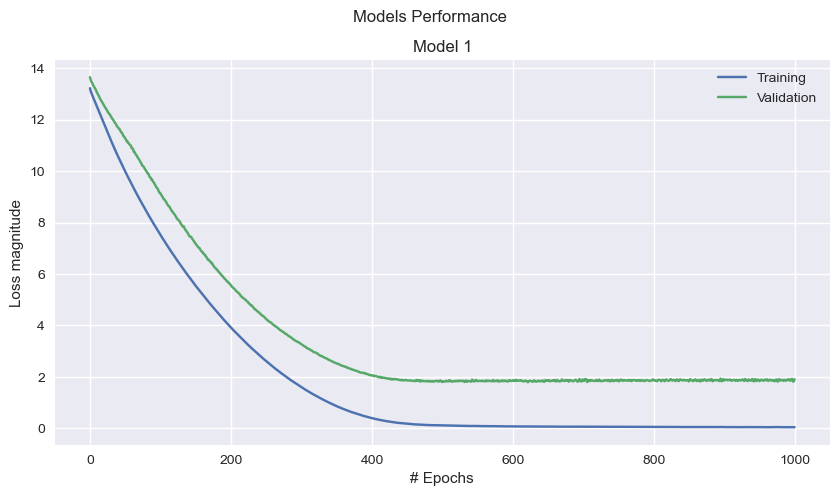

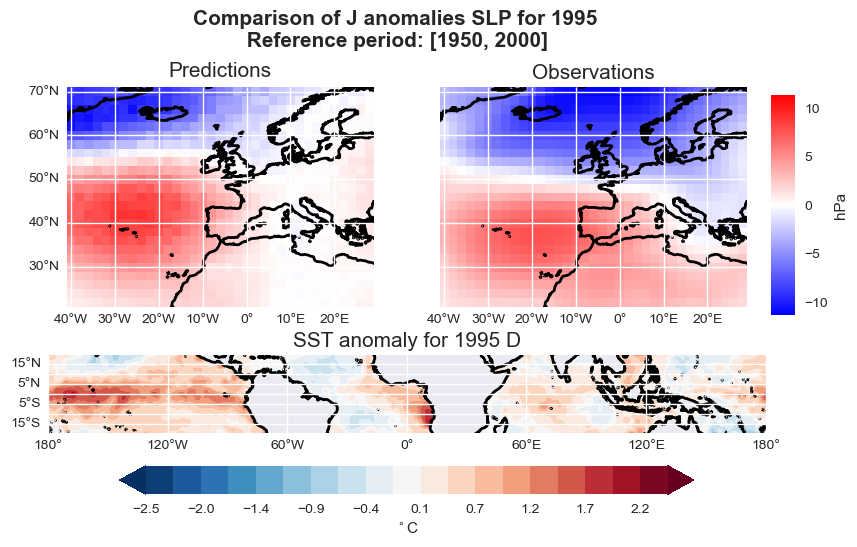

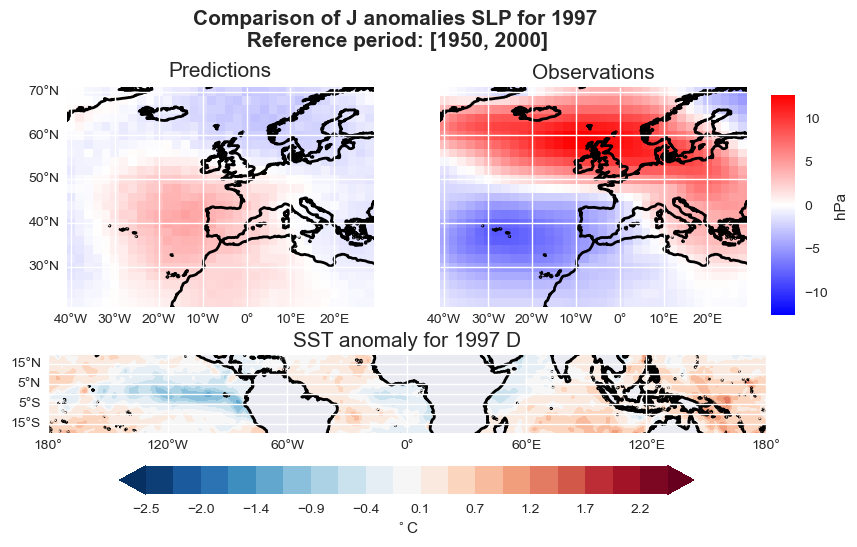

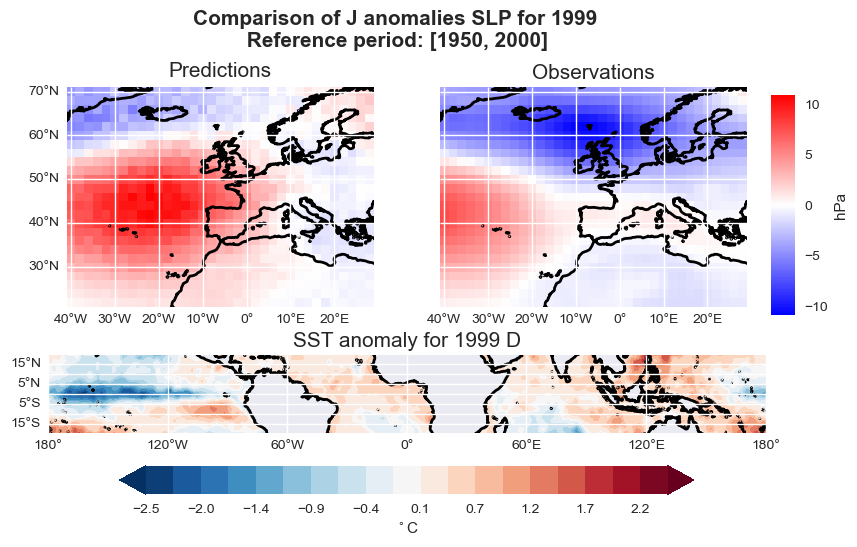

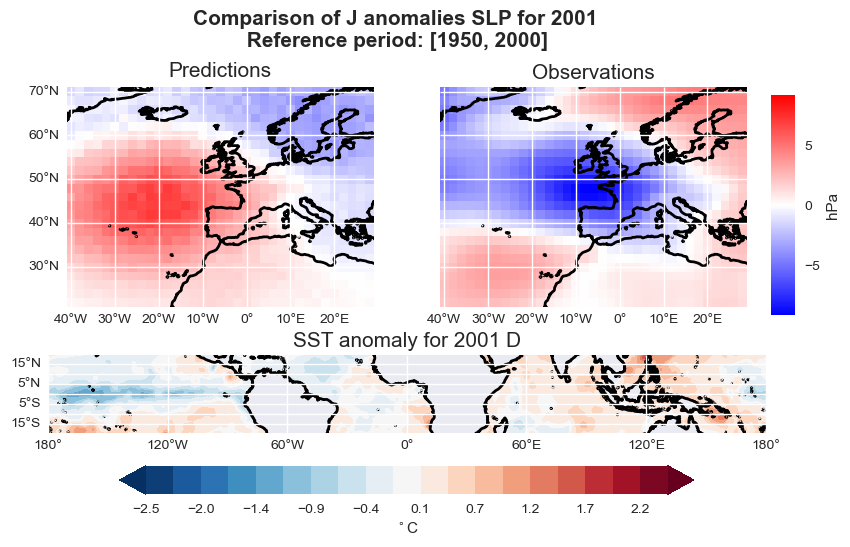

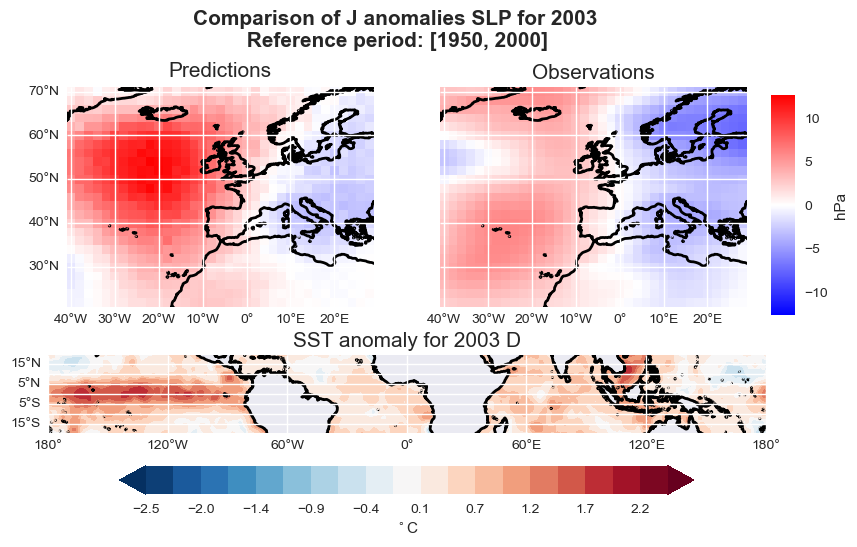

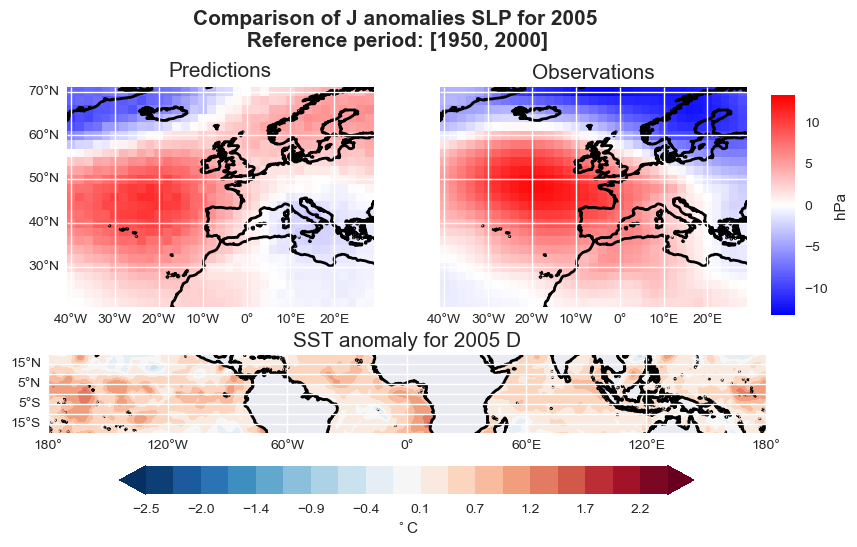

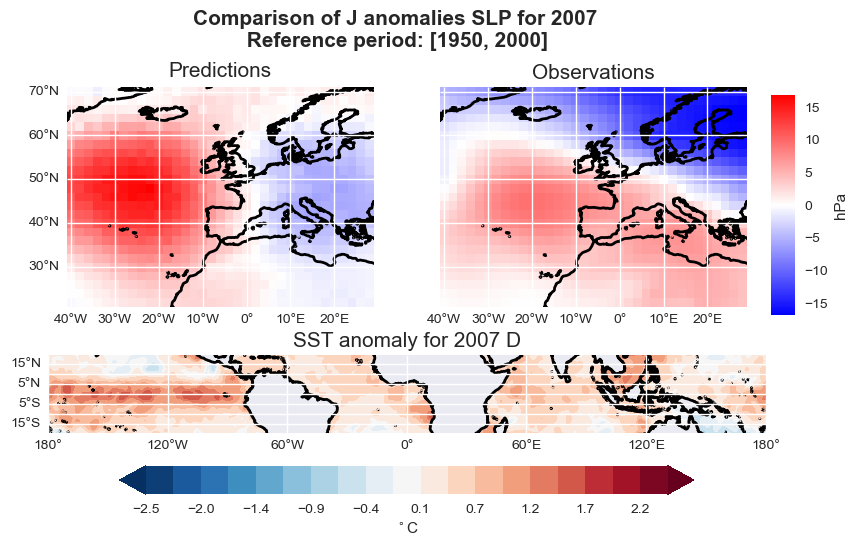

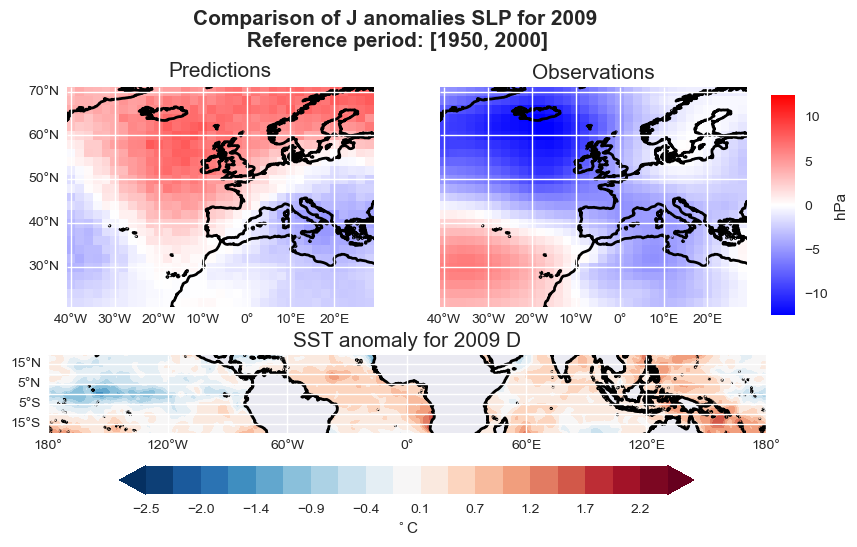

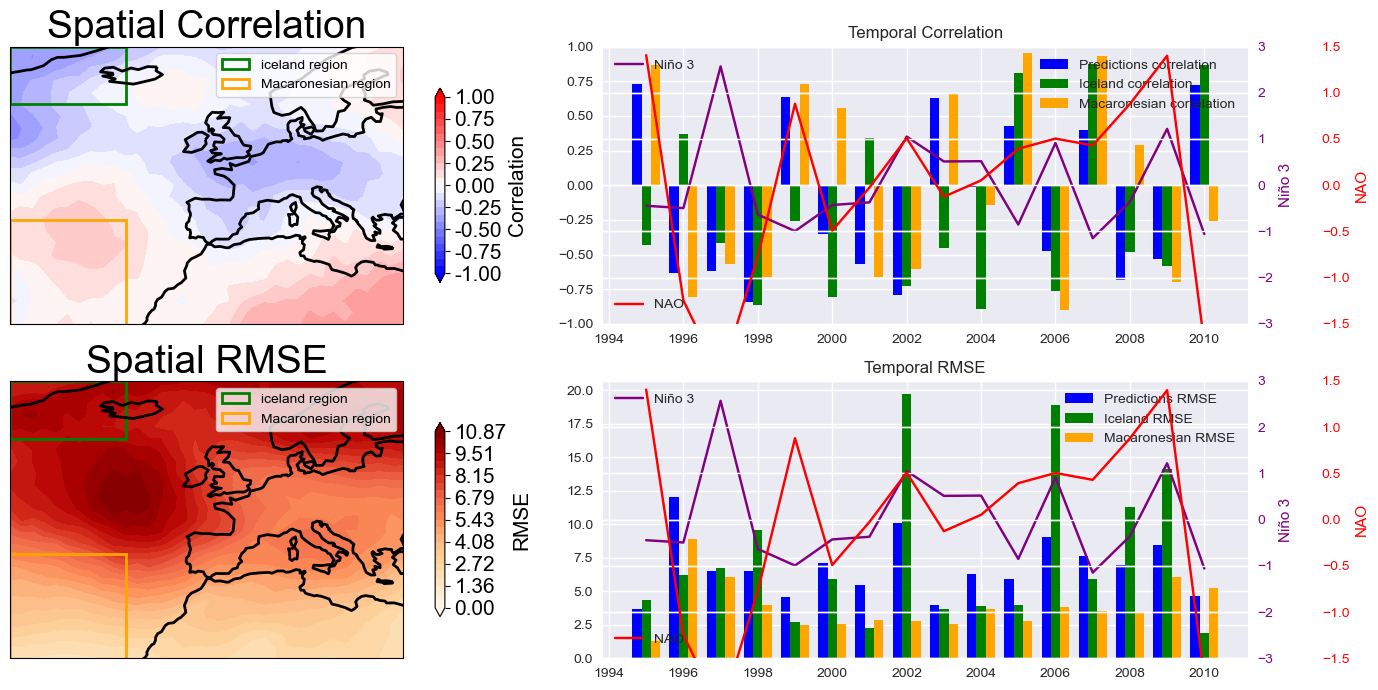

In [12]:
era_slp_regrid,lat_slp,lon_slp = data_mining('Datasets/'+path_era_slp, lat_lims_slp, lon_lims_slp, time_lims, scale=100, rotate_180=True, regrid=True, regrid_degree=2,overlapping=False,variable_name='msl')
had_sst_regrid,lat_sst,lon_sst = data_mining('Datasets/'+path_had_sst, lat_lims_sst, lon_lims_sst, time_lims, scale=1, rotate_360=True, regrid=False, regrid_degree=2,overlapping=True,variable_name='sst')
data_slp,anom_slp,norm_slp,mean_slp,std_slp= data_selection(era_slp_regrid, months_slp, years,months_skip_slp,years_finally_slp,reference_period)
data_sst,anom_sst,norm_sst,mean_sst,std_sst= data_selection(had_sst_regrid, months_sst, years,months_skip_sst,years_finally_slp,reference_period)
X_train,X_valid,X_test,Y_train,Y_valid,Y_test= data_split(train_years,validation_years,testing_years,norm_sst,norm_slp, predictor_nans=True, predictant_nans=False)
print('Preprocessing done....... now training the model')
input_shape,output_shape = X_train.shape[1], Y_train.shape[1:3]
model1 = create_model(input_shape,output_shape, layer_sizes, activations, dropout_rates, kernel_regularizer)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MeanSquaredError())
record1= model1.fit(np.array(X_train), np.array(Y_train),epochs=epochs, verbose=0, validation_data=(np.array(X_valid), np.array(Y_valid)))
performance_plot(record1)
print("Evaluate on test data")
predicted1,correct_value= evaluation(model1,X_test,Y_test,lon_slp,lat_slp,std_slp)
X_test_anom= data_sst.sel(year=slice(str(testing_years[0]),str(testing_years[1])))-data_sst.sel(year=slice(str(reference_period[0]),str(reference_period[1]))).mean(dim='year') #desestandarizamos
for i in range(1995,2011,2):
    year=i
    figura= outputs_path+'Comparison'+str(year)+'.png'
    DibujoMapados(lon_slp,lat_slp,lon_sst, lat_sst, X_test_anom.sel(year=year),predicted1.sel(time=year),correct_value.sel(year=year),mapbar,unidades,titulo1,titulo2,subtitulo1,periodo,subtitulo2,figura,year)
nino3= nino_index(lon_nino3,lat_nino3,xr.open_dataset('Datasets/'+path_had_sst),time_period=[1995,2010])
nao= nao_index(Azores,icelandia,xr.open_dataset('Datasets/'+path_era_slp),time_period=[1995,2010])
nao_index_grouped= nao.groupby('time.month')
nao_index_january = nao_index_grouped[1]
#nao_index_djf= (np.array(nao_index_january.msl.drop_sel(time='1995-01'))+np.array(nao_index_february.msl.drop_sel(time='1995-02'))+np.array(nao_index_december.msl.drop_sel(time='2010-12')))/3
correlations(predicted1,correct_value,outputs_path,lat_iceland,lon_iceland,lat_macaronesian,lon_macaronesian,time_series=True,index_1=nino3.sst,index_1_name='Niño 3',index_2=nao_index_january.msl,index_2_name='NAO')